# Task B: Meta-Learning Perfomance Prediction

In this task, you will use information on training parameters and metadata on multiple OpenML dataset to train a performance predictor that performs well even for unseen datasets. You are provided with config parameters and metafeatures for six datasets. The datasets are split into training datasets and test datasets and you should only train on the training datasets.

For questions, you can contact zimmerl@informatik.uni-freiburg.de

__Note: Please use the dataloading and splits you are provided with in this notebook.__

## Specifications:

* Data: six_datasets_lw.json
* Number of datasets: 6
* Training datasets: higgs, vehicle, adult, volkert
* Test datasets: Fashion-MNIST, jasmine
* Number of configurations: 2000
* Available data: architecture parameters and hyperparameters, metafeatures 
* Target: final validation accuracy
* Evaluation metric: MSE

## Importing

Note: There are 51 steps logged, 50 epochs plus the 0th epoch, prior to any weight updates.

In [1]:
%%capture
%cd ..
#external
import numpy as np
import json
import sys
import matplotlib.pyplot as plt

#pytorch
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

#local
sys.path.append("../")
from networks.MyMLP import MyMLP
from func.train_eval import train_model, eval_model
from func.load_data import prepare_dataloaders, load_data_from_file

## Cuda config

In [2]:
torch.cuda.empty_cache()

## Load data

In [3]:
X_train, X_metafeatures_train, y_train, X_val, X_metafeatures_val, y_val, X_test, X_metafeatures_test, y_test    =   load_data_from_file("cached/six_datasets_lw.json", "cached/metafeatures_6.json")

Path to hyperparameters data:  c:\Users\saipr\Documents\Deep Learning\ws19\LCBench_DL/cached/six_datasets_lw.json
Path to metafeatures data:  c:\Users\saipr\Documents\Deep Learning\ws19\LCBench_DL/cached/metafeatures_6.json
==&gt; Loading data...
==&gt; No cached data found or cache set to False.
==&gt; Reading json data...
==&gt; Done.
Available datasets:  [&#39;Fashion-MNIST&#39;, &#39;adult&#39;, &#39;higgs&#39;, &#39;jasmine&#39;, &#39;vehicle&#39;, &#39;volkert&#39;]
Train-Validation-Test split: 6000-2000-4000


In [4]:
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)
print()
print("Y_Train:",y_train.shape)
print("Y_val:",y_val.shape)
print("Y_Test:",y_test.shape)
print()
print("X_metafeatures_train:",X_metafeatures_train.shape)
print("X_metafeatures_val:" ,X_metafeatures_val.shape)
print("X_metafeatures_test:" , X_metafeatures_test.shape)

X_train: (6000,)
X_val: (2000,)
X_test: (4000,)

Y_Train: (6000,)
Y_val: (2000,)
Y_Test: (4000,)

X_metafeatures_train: (6000,)
X_metafeatures_val: (2000,)
X_metafeatures_test: (4000,)


## 

# Prepare data
## Preprocess data + Create dataloaders for the preprocessed data tensors

In [5]:
batch_size = 4

train_dataloader = prepare_dataloaders(X_hp=X_train, X_mf=X_metafeatures_train, y= y_train, X_scaling="minmax",y_scaling="minmax",batch_size=batch_size, typeD = "tensor")
validation_dataloader = prepare_dataloaders(X_hp=X_val, X_mf=X_metafeatures_val, y= y_val, X_scaling="minmax",y_scaling="minmax",batch_size=batch_size, typeD = "tensor")
test_dataloader = prepare_dataloaders(X_hp=X_test, X_mf=X_metafeatures_test, y= y_test, X_scaling="minmax", y_scaling="minmax",batch_size=batch_size, typeD = "tensor")

## Check the data in the tensors

In [6]:
for x,  y in train_dataloader:
    print("X- minibatched: ", x)
    print("y- minibatched: ", y)
    break

X- minibatched:  tensor([[3.3333e-01, 1.4085e-04, 4.5601e-01, 1.8182e-02, 6.3946e-01, 5.2083e-03,
         2.3918e-01, 1.0000e+00, 0.0000e+00, 5.1190e-04, 1.0000e+00, 7.1571e-01,
         7.3652e-02, 1.0000e+00, 1.0000e+00, 2.5875e-01, 1.0000e+00, 5.8947e-01,
         1.0000e+00, 1.0000e+00, 9.4840e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 7.7516e-01, 9.9183e-01, 4.8192e-01, 2.4961e-01, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 4.9377e-01, 1.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
         6.5463e-01, 8.7882e-01, 2.6878e-01, 1.0000e+00, 1.0000e+00, 7.2777e-01,
         7.7297e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00],
        [6.6667e-01, 1.4250e-02, 2.0724e-01, 8.3030e-01, 9.3943e-01, 4.4583e-01,
         3.5478e-01, 2.2646e-01, 5.5606e-01, 1.0000e+00, 7.0346e-02, 0.0000e+00,
         0.0000e+00, 2.3139e-03, 5.1282e-02, 3.4863e-02, 1.6651e-03, 0

## Training and scoring

In [7]:
MyMLP = MyMLP(4, 0.5, 55, 1)
print("Model:")
print(MyMLP.model)
model = MyMLP.model
n_epochs = 70
optimizer  = optim.Adam(model.parameters(), lr=1e-05)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, eta_min=1e-05)
criterion = nn.MSELoss()
state_dict, training_losses, validation_losses = train_model(train_dataloader, validation_dataloader, n_epochs, model, optimizer, scheduler, criterion)

Model:
Sequential(
  (fc1): Linear(in_features=55, out_features=41, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (relu1): ReLU()
  (fc2): Linear(in_features=41, out_features=27, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (relu2): ReLU()
  (fc3): Linear(in_features=27, out_features=13, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (relu3): ReLU()
  (fc4): Linear(in_features=13, out_features=1, bias=True)
)
[1] Training loss: 0.3626	 Validation loss: 0.2908
[2] Training loss: 0.2487	 Validation loss: 0.1784
[3] Training loss: 0.2000	 Validation loss: 0.1261
[4] Training loss: 0.1787	 Validation loss: 0.1021
[5] Training loss: 0.1610	 Validation loss: 0.0859
[6] Training loss: 0.1446	 Validation loss: 0.0760
[7] Training loss: 0.1362	 Validation loss: 0.0682
[8] Training loss: 0.1257	 Validation loss: 0.0612
[9] Training loss: 0.1202	 Validation loss: 0.0553
[10] Training loss: 0.1084	 Validation loss: 0.0506
[11] Training loss: 0.1060	 Validation loss

In [8]:
model.load_state_dict(state_dict)
test_losses = eval_model(test_dataloader, model, criterion)

Final test loss: 0.0687


# Plotting

## Training - Validation Curve

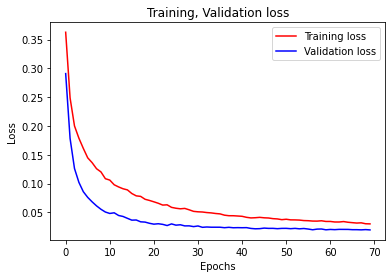

In [9]:
epochs = range(n_epochs)
plt.plot(epochs, training_losses, 'r', label='Training loss')
plt.plot(epochs, validation_losses, 'b', label='Validation loss')
plt.title('Training, Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()